**Import Library**


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2
import torch
from tqdm import tqdm
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2

In [ ]:
!nvidia-smi

Thu Feb  2 06:10:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**MENGHUBUNGKAN GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**`AKTIFKAN SAVE MODEL `**

In [ ]:
CHECKPOINT_FILE = "1152KaggleBest.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

**MELAKUKAN AUGMENTASI**

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

**MEMBUAT FUNGSI UNTUK MENGGABUNGKAN ANNOTASI BOX DAN GAMBAR**

In [ ]:
class PestDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]

            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

**MEMANGGIL DATASET UNTUK TRAINING**

In [ ]:
#Memanggil dataset
dataset_path = "/content/drive/MyDrive/Ta/Dataset/"

In [ ]:
# memanggil file annotation untuk membuat box di data train 
coco = COCO(os.path.join(dataset_path, 'train/','_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=5.15s)
creating index...
index created!


{0: {'id': 0, 'name': 'Pest', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Pest'},
 2: {'id': 2, 'name': 'Sehat', 'supercategory': 'Pest'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Pest'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Pest'}}

In [ ]:
# MEMANGGIL NAMA LABEL 
classes = [i[1]['name'] for i in categories.items()]
classes

['Pest', 'Belalang', 'Sehat', 'Ulat', 'Wereng']

**MEMANGGIL DATA TRAIN DAN DATA VALIDASI**

In [ ]:
#  DATA TRAIN
train_dataset = PestDetection(root=dataset_path, transforms=get_transforms(True))
train_dataset[100]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


(tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431]],
 
         [[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431]],
 
         [[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ...,

In [ ]:
#  DATA VALIDASI
test_dataset = PestDetection(root=dataset_path, split="valid", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


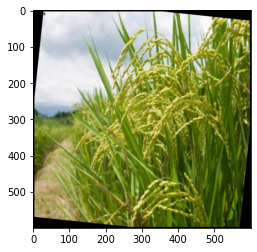

In [ ]:
# CONOH DATA TRAIN YANG DI PANGGIL
sample = train_dataset[8]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

**MEMANGGIL TRUE LABEL**

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Ta/Dataset/valid/_classes.csv', sep=',')



In [ ]:
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

In [ ]:
test_labels = labels.apply(get_label, axis=1)



**`MEMANGGIL LIBRARY MODEL FAST RCNN `**

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

**MEMBUAT FUNGSI SAVE MODEL HASIL TRAINING**

In [ ]:
def save_checkpoint(state, filename="faster_rcnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

**MEMBUAT FUNGSI TRAINING**

In [ ]:
best_loss = np.inf
def train_one_epoch(model, optimizer, loader, device, epoch):
    global best_loss
    model.to(device)
    model.train()
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(loader):
      
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)
          
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
    
    if np.mean(all_losses) < best_loss:
      best_loss = np.mean(all_losses)
      if SAVE_MODEL:
            print("Model improved, saving...")
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    return(np.mean(all_losses))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

**` RUNNING 5-KFOLD TRAINING`**

FOLD 0
--------------------------------


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 0, lr: 0.000010, loss: 0.252094, loss_classifier: 0.141053, loss_box: 0.094970, loss_rpn_box: 0.007390, loss_object: 0.008681


100%|██████████| 161/161 [02:04<00:00,  1.29it/s]


Epoch 1, lr: 0.000010, loss: 0.127084, loss_classifier: 0.052425, loss_box: 0.063778, loss_rpn_box: 0.005861, loss_object: 0.005021


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 2, lr: 0.000010, loss: 0.107297, loss_classifier: 0.043535, loss_box: 0.054774, loss_rpn_box: 0.005361, loss_object: 0.003627


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 3, lr: 0.000010, loss: 0.092882, loss_classifier: 0.037849, loss_box: 0.047103, loss_rpn_box: 0.005017, loss_object: 0.002914


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 4, lr: 0.000010, loss: 0.087957, loss_classifier: 0.036441, loss_box: 0.045021, loss_rpn_box: 0.004679, loss_object: 0.001815


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 5, lr: 0.000010, loss: 0.078406, loss_classifier: 0.032343, loss_box: 0.039663, loss_rpn_box: 0.004427, loss_object: 0.001973


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 6, lr: 0.000010, loss: 0.071541, loss_classifier: 0.029143, loss_box: 0.036761, loss_rpn_box: 0.004251, loss_object: 0.001386


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 7, lr: 0.000010, loss: 0.065790, loss_classifier: 0.026308, loss_box: 0.034139, loss_rpn_box: 0.004075, loss_object: 0.001268


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 8, lr: 0.000010, loss: 0.060675, loss_classifier: 0.023536, loss_box: 0.032140, loss_rpn_box: 0.003810, loss_object: 0.001189


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 9, lr: 0.000010, loss: 0.059769, loss_classifier: 0.022784, loss_box: 0.031989, loss_rpn_box: 0.003692, loss_object: 0.001304


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 10, lr: 0.000010, loss: 0.054280, loss_classifier: 0.020195, loss_box: 0.029672, loss_rpn_box: 0.003547, loss_object: 0.000866


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 11, lr: 0.000010, loss: 0.050871, loss_classifier: 0.018699, loss_box: 0.027834, loss_rpn_box: 0.003345, loss_object: 0.000993


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 12, lr: 0.000010, loss: 0.046810, loss_classifier: 0.017399, loss_box: 0.025199, loss_rpn_box: 0.003144, loss_object: 0.001068


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 13, lr: 0.000010, loss: 0.044107, loss_classifier: 0.016125, loss_box: 0.023916, loss_rpn_box: 0.003027, loss_object: 0.001039


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 14, lr: 0.000010, loss: 0.041654, loss_classifier: 0.015104, loss_box: 0.022765, loss_rpn_box: 0.002984, loss_object: 0.000802


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 15, lr: 0.000010, loss: 0.040040, loss_classifier: 0.014017, loss_box: 0.022527, loss_rpn_box: 0.002705, loss_object: 0.000791


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 16, lr: 0.000010, loss: 0.036677, loss_classifier: 0.012988, loss_box: 0.020496, loss_rpn_box: 0.002679, loss_object: 0.000515


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 17, lr: 0.000010, loss: 0.036805, loss_classifier: 0.012570, loss_box: 0.021013, loss_rpn_box: 0.002657, loss_object: 0.000564


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 18, lr: 0.000010, loss: 0.032639, loss_classifier: 0.010701, loss_box: 0.019082, loss_rpn_box: 0.002494, loss_object: 0.000361


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 19, lr: 0.000010, loss: 0.032254, loss_classifier: 0.011018, loss_box: 0.018050, loss_rpn_box: 0.002546, loss_object: 0.000639


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 20, lr: 0.000010, loss: 0.032628, loss_classifier: 0.011109, loss_box: 0.018559, loss_rpn_box: 0.002436, loss_object: 0.000523


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 21, lr: 0.000010, loss: 0.033232, loss_classifier: 0.012075, loss_box: 0.018146, loss_rpn_box: 0.002384, loss_object: 0.000626


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 22, lr: 0.000010, loss: 0.029752, loss_classifier: 0.010413, loss_box: 0.016637, loss_rpn_box: 0.002262, loss_object: 0.000440


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 23, lr: 0.000010, loss: 0.028517, loss_classifier: 0.009873, loss_box: 0.015994, loss_rpn_box: 0.002143, loss_object: 0.000506


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 24, lr: 0.000010, loss: 0.027700, loss_classifier: 0.009355, loss_box: 0.015861, loss_rpn_box: 0.002099, loss_object: 0.000384


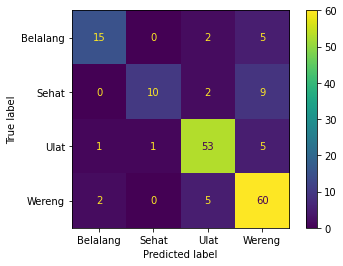

              precision    recall  f1-score   support

    Belalang       0.83      0.68      0.75        22
       Sehat       0.91      0.48      0.62        21
        Ulat       0.85      0.88      0.87        60
      Wereng       0.76      0.90      0.82        67

    accuracy                           0.81       170
   macro avg       0.84      0.73      0.77       170
weighted avg       0.82      0.81      0.80       170

FOLD 1
--------------------------------


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 0, lr: 0.000010, loss: 0.027862, loss_classifier: 0.009028, loss_box: 0.016360, loss_rpn_box: 0.002063, loss_object: 0.000411


100%|██████████| 161/161 [02:08<00:00,  1.26it/s]


Epoch 1, lr: 0.000010, loss: 0.026529, loss_classifier: 0.008425, loss_box: 0.015661, loss_rpn_box: 0.002086, loss_object: 0.000358


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 2, lr: 0.000010, loss: 0.026760, loss_classifier: 0.008756, loss_box: 0.015531, loss_rpn_box: 0.002031, loss_object: 0.000441


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 3, lr: 0.000010, loss: 0.025940, loss_classifier: 0.008175, loss_box: 0.015331, loss_rpn_box: 0.001964, loss_object: 0.000470


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 4, lr: 0.000010, loss: 0.026106, loss_classifier: 0.009137, loss_box: 0.014711, loss_rpn_box: 0.001861, loss_object: 0.000397


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 5, lr: 0.000010, loss: 0.025566, loss_classifier: 0.008620, loss_box: 0.014702, loss_rpn_box: 0.001846, loss_object: 0.000398


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 6, lr: 0.000010, loss: 0.024193, loss_classifier: 0.008243, loss_box: 0.013981, loss_rpn_box: 0.001727, loss_object: 0.000242


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 7, lr: 0.000010, loss: 0.022499, loss_classifier: 0.007424, loss_box: 0.013179, loss_rpn_box: 0.001693, loss_object: 0.000202


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 8, lr: 0.000010, loss: 0.023725, loss_classifier: 0.007920, loss_box: 0.013972, loss_rpn_box: 0.001631, loss_object: 0.000201


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 9, lr: 0.000010, loss: 0.023332, loss_classifier: 0.008184, loss_box: 0.013354, loss_rpn_box: 0.001624, loss_object: 0.000169


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 10, lr: 0.000010, loss: 0.021983, loss_classifier: 0.007340, loss_box: 0.012780, loss_rpn_box: 0.001568, loss_object: 0.000295


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 11, lr: 0.000010, loss: 0.021550, loss_classifier: 0.007397, loss_box: 0.012387, loss_rpn_box: 0.001558, loss_object: 0.000208


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 12, lr: 0.000010, loss: 0.021272, loss_classifier: 0.007266, loss_box: 0.012219, loss_rpn_box: 0.001519, loss_object: 0.000269


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 13, lr: 0.000010, loss: 0.020998, loss_classifier: 0.006834, loss_box: 0.012451, loss_rpn_box: 0.001459, loss_object: 0.000254


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 14, lr: 0.000010, loss: 0.020510, loss_classifier: 0.006675, loss_box: 0.012129, loss_rpn_box: 0.001451, loss_object: 0.000255


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 15, lr: 0.000010, loss: 0.019798, loss_classifier: 0.006509, loss_box: 0.011782, loss_rpn_box: 0.001353, loss_object: 0.000154


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 16, lr: 0.000010, loss: 0.019255, loss_classifier: 0.006240, loss_box: 0.011434, loss_rpn_box: 0.001380, loss_object: 0.000201


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 17, lr: 0.000010, loss: 0.020088, loss_classifier: 0.006381, loss_box: 0.012166, loss_rpn_box: 0.001358, loss_object: 0.000184


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 18, lr: 0.000010, loss: 0.019202, loss_classifier: 0.006768, loss_box: 0.010902, loss_rpn_box: 0.001307, loss_object: 0.000225


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 19, lr: 0.000010, loss: 0.018990, loss_classifier: 0.006433, loss_box: 0.010981, loss_rpn_box: 0.001329, loss_object: 0.000247


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 20, lr: 0.000010, loss: 0.017841, loss_classifier: 0.006328, loss_box: 0.010112, loss_rpn_box: 0.001241, loss_object: 0.000160


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 21, lr: 0.000010, loss: 0.017312, loss_classifier: 0.005804, loss_box: 0.010163, loss_rpn_box: 0.001160, loss_object: 0.000184


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 22, lr: 0.000010, loss: 0.016593, loss_classifier: 0.005756, loss_box: 0.009475, loss_rpn_box: 0.001150, loss_object: 0.000213


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 23, lr: 0.000010, loss: 0.015767, loss_classifier: 0.005314, loss_box: 0.009163, loss_rpn_box: 0.001137, loss_object: 0.000153


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 24, lr: 0.000010, loss: 0.016988, loss_classifier: 0.005570, loss_box: 0.010018, loss_rpn_box: 0.001173, loss_object: 0.000227


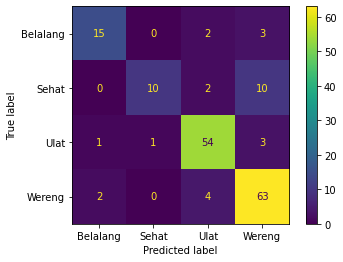

              precision    recall  f1-score   support

    Belalang       0.83      0.75      0.79        20
       Sehat       0.91      0.45      0.61        22
        Ulat       0.87      0.92      0.89        59
      Wereng       0.80      0.91      0.85        69

    accuracy                           0.84       170
   macro avg       0.85      0.76      0.78       170
weighted avg       0.84      0.84      0.83       170

FOLD 2
--------------------------------


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 0, lr: 0.000010, loss: 0.018013, loss_classifier: 0.005834, loss_box: 0.010758, loss_rpn_box: 0.001176, loss_object: 0.000245


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 1, lr: 0.000010, loss: 0.017858, loss_classifier: 0.006119, loss_box: 0.010367, loss_rpn_box: 0.001200, loss_object: 0.000172


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 2, lr: 0.000010, loss: 0.017595, loss_classifier: 0.006038, loss_box: 0.010132, loss_rpn_box: 0.001138, loss_object: 0.000287


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 3, lr: 0.000010, loss: 0.015621, loss_classifier: 0.005183, loss_box: 0.009256, loss_rpn_box: 0.001056, loss_object: 0.000126


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 4, lr: 0.000010, loss: 0.016086, loss_classifier: 0.005729, loss_box: 0.009159, loss_rpn_box: 0.001074, loss_object: 0.000125


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 5, lr: 0.000010, loss: 0.015797, loss_classifier: 0.005430, loss_box: 0.009247, loss_rpn_box: 0.000992, loss_object: 0.000127


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 6, lr: 0.000010, loss: 0.016151, loss_classifier: 0.005654, loss_box: 0.009395, loss_rpn_box: 0.000970, loss_object: 0.000132


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 7, lr: 0.000010, loss: 0.015284, loss_classifier: 0.005048, loss_box: 0.009052, loss_rpn_box: 0.000992, loss_object: 0.000193


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 8, lr: 0.000010, loss: 0.015865, loss_classifier: 0.005448, loss_box: 0.009344, loss_rpn_box: 0.000963, loss_object: 0.000111


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 9, lr: 0.000010, loss: 0.014945, loss_classifier: 0.005264, loss_box: 0.008606, loss_rpn_box: 0.000957, loss_object: 0.000118


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 10, lr: 0.000010, loss: 0.013931, loss_classifier: 0.004722, loss_box: 0.008136, loss_rpn_box: 0.000937, loss_object: 0.000136


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 11, lr: 0.000010, loss: 0.015832, loss_classifier: 0.005874, loss_box: 0.008835, loss_rpn_box: 0.000941, loss_object: 0.000182


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 12, lr: 0.000010, loss: 0.015349, loss_classifier: 0.005404, loss_box: 0.008863, loss_rpn_box: 0.000940, loss_object: 0.000142


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 13, lr: 0.000010, loss: 0.013847, loss_classifier: 0.004758, loss_box: 0.008093, loss_rpn_box: 0.000882, loss_object: 0.000114


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 14, lr: 0.000010, loss: 0.013694, loss_classifier: 0.004844, loss_box: 0.007902, loss_rpn_box: 0.000829, loss_object: 0.000120


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 15, lr: 0.000010, loss: 0.013521, loss_classifier: 0.004819, loss_box: 0.007769, loss_rpn_box: 0.000819, loss_object: 0.000113


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 16, lr: 0.000010, loss: 0.013487, loss_classifier: 0.004683, loss_box: 0.007936, loss_rpn_box: 0.000777, loss_object: 0.000092


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 17, lr: 0.000010, loss: 0.018806, loss_classifier: 0.007323, loss_box: 0.009759, loss_rpn_box: 0.001219, loss_object: 0.000504


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 18, lr: 0.000010, loss: 0.013369, loss_classifier: 0.004699, loss_box: 0.007779, loss_rpn_box: 0.000794, loss_object: 0.000097


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 19, lr: 0.000010, loss: 0.013375, loss_classifier: 0.004730, loss_box: 0.007643, loss_rpn_box: 0.000788, loss_object: 0.000214


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 20, lr: 0.000010, loss: 0.013306, loss_classifier: 0.004712, loss_box: 0.007661, loss_rpn_box: 0.000801, loss_object: 0.000132


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 21, lr: 0.000010, loss: 0.012394, loss_classifier: 0.004350, loss_box: 0.007194, loss_rpn_box: 0.000737, loss_object: 0.000114


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 22, lr: 0.000010, loss: 0.012335, loss_classifier: 0.004308, loss_box: 0.007129, loss_rpn_box: 0.000744, loss_object: 0.000155


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 23, lr: 0.000010, loss: 0.013310, loss_classifier: 0.004466, loss_box: 0.007969, loss_rpn_box: 0.000767, loss_object: 0.000109


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 24, lr: 0.000010, loss: 0.012838, loss_classifier: 0.004764, loss_box: 0.007234, loss_rpn_box: 0.000740, loss_object: 0.000100


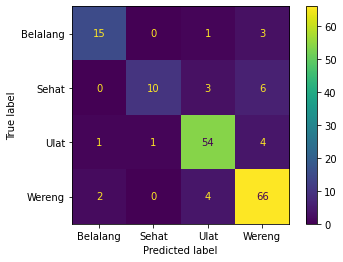

              precision    recall  f1-score   support

    Belalang       0.83      0.79      0.81        19
       Sehat       0.91      0.53      0.67        19
        Ulat       0.87      0.90      0.89        60
      Wereng       0.84      0.92      0.87        72

    accuracy                           0.85       170
   macro avg       0.86      0.78      0.81       170
weighted avg       0.86      0.85      0.85       170

FOLD 3
--------------------------------


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 0, lr: 0.000010, loss: 0.013379, loss_classifier: 0.005061, loss_box: 0.007344, loss_rpn_box: 0.000744, loss_object: 0.000229


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 1, lr: 0.000010, loss: 0.013851, loss_classifier: 0.004843, loss_box: 0.008047, loss_rpn_box: 0.000843, loss_object: 0.000118


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 2, lr: 0.000010, loss: 0.012071, loss_classifier: 0.004446, loss_box: 0.006808, loss_rpn_box: 0.000701, loss_object: 0.000116


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 3, lr: 0.000010, loss: 0.011133, loss_classifier: 0.004152, loss_box: 0.006201, loss_rpn_box: 0.000684, loss_object: 0.000096


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 4, lr: 0.000010, loss: 0.013129, loss_classifier: 0.005063, loss_box: 0.007217, loss_rpn_box: 0.000683, loss_object: 0.000166


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 5, lr: 0.000010, loss: 0.012084, loss_classifier: 0.004340, loss_box: 0.007014, loss_rpn_box: 0.000657, loss_object: 0.000073


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 6, lr: 0.000010, loss: 0.013173, loss_classifier: 0.004665, loss_box: 0.007494, loss_rpn_box: 0.000827, loss_object: 0.000187


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 7, lr: 0.000010, loss: 0.013765, loss_classifier: 0.005393, loss_box: 0.007487, loss_rpn_box: 0.000739, loss_object: 0.000147


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 8, lr: 0.000010, loss: 0.012637, loss_classifier: 0.004815, loss_box: 0.006992, loss_rpn_box: 0.000726, loss_object: 0.000104


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 9, lr: 0.000010, loss: 0.011874, loss_classifier: 0.004190, loss_box: 0.006894, loss_rpn_box: 0.000666, loss_object: 0.000124


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 10, lr: 0.000010, loss: 0.011818, loss_classifier: 0.004316, loss_box: 0.006759, loss_rpn_box: 0.000662, loss_object: 0.000080


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 11, lr: 0.000010, loss: 0.011016, loss_classifier: 0.004200, loss_box: 0.006126, loss_rpn_box: 0.000598, loss_object: 0.000093


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 12, lr: 0.000010, loss: 0.012092, loss_classifier: 0.004366, loss_box: 0.006886, loss_rpn_box: 0.000667, loss_object: 0.000173


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 13, lr: 0.000010, loss: 0.010476, loss_classifier: 0.003714, loss_box: 0.006077, loss_rpn_box: 0.000604, loss_object: 0.000081


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 14, lr: 0.000010, loss: 0.012312, loss_classifier: 0.004510, loss_box: 0.006905, loss_rpn_box: 0.000755, loss_object: 0.000142


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 15, lr: 0.000010, loss: 0.012251, loss_classifier: 0.004607, loss_box: 0.006864, loss_rpn_box: 0.000692, loss_object: 0.000087


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 16, lr: 0.000010, loss: 0.010613, loss_classifier: 0.003924, loss_box: 0.005935, loss_rpn_box: 0.000614, loss_object: 0.000140


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 17, lr: 0.000010, loss: 0.011824, loss_classifier: 0.004413, loss_box: 0.006670, loss_rpn_box: 0.000632, loss_object: 0.000109


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 18, lr: 0.000010, loss: 0.011561, loss_classifier: 0.004312, loss_box: 0.006571, loss_rpn_box: 0.000596, loss_object: 0.000081


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 19, lr: 0.000010, loss: 0.010551, loss_classifier: 0.003747, loss_box: 0.006142, loss_rpn_box: 0.000594, loss_object: 0.000068


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 20, lr: 0.000010, loss: 0.010406, loss_classifier: 0.003775, loss_box: 0.005921, loss_rpn_box: 0.000597, loss_object: 0.000113


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 21, lr: 0.000010, loss: 0.010407, loss_classifier: 0.003823, loss_box: 0.005873, loss_rpn_box: 0.000536, loss_object: 0.000175


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 22, lr: 0.000010, loss: 0.010164, loss_classifier: 0.003720, loss_box: 0.005868, loss_rpn_box: 0.000535, loss_object: 0.000041


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 23, lr: 0.000010, loss: 0.009861, loss_classifier: 0.003787, loss_box: 0.005468, loss_rpn_box: 0.000528, loss_object: 0.000078


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 24, lr: 0.000010, loss: 0.010198, loss_classifier: 0.003951, loss_box: 0.005634, loss_rpn_box: 0.000523, loss_object: 0.000090


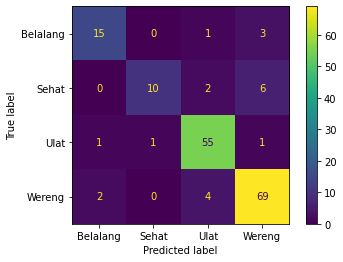

              precision    recall  f1-score   support

    Belalang       0.83      0.79      0.81        19
       Sehat       0.91      0.56      0.69        18
        Ulat       0.89      0.95      0.92        58
      Wereng       0.87      0.92      0.90        75

    accuracy                           0.88       170
   macro avg       0.88      0.80      0.83       170
weighted avg       0.88      0.88      0.87       170

FOLD 4
--------------------------------


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 0, lr: 0.000010, loss: 0.011037, loss_classifier: 0.004193, loss_box: 0.006161, loss_rpn_box: 0.000574, loss_object: 0.000109


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 1, lr: 0.000010, loss: 0.011099, loss_classifier: 0.004105, loss_box: 0.006312, loss_rpn_box: 0.000576, loss_object: 0.000106


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 2, lr: 0.000010, loss: 0.009591, loss_classifier: 0.003600, loss_box: 0.005445, loss_rpn_box: 0.000493, loss_object: 0.000053


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 3, lr: 0.000010, loss: 0.009628, loss_classifier: 0.003556, loss_box: 0.005492, loss_rpn_box: 0.000476, loss_object: 0.000104


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 4, lr: 0.000010, loss: 0.010524, loss_classifier: 0.003873, loss_box: 0.006058, loss_rpn_box: 0.000499, loss_object: 0.000095


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 5, lr: 0.000010, loss: 0.010577, loss_classifier: 0.004052, loss_box: 0.005867, loss_rpn_box: 0.000534, loss_object: 0.000123


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 6, lr: 0.000010, loss: 0.009798, loss_classifier: 0.003640, loss_box: 0.005587, loss_rpn_box: 0.000507, loss_object: 0.000064


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 7, lr: 0.000010, loss: 0.010366, loss_classifier: 0.003739, loss_box: 0.006036, loss_rpn_box: 0.000512, loss_object: 0.000077


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 8, lr: 0.000010, loss: 0.010014, loss_classifier: 0.003762, loss_box: 0.005590, loss_rpn_box: 0.000540, loss_object: 0.000122


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 9, lr: 0.000010, loss: 0.009971, loss_classifier: 0.003652, loss_box: 0.005766, loss_rpn_box: 0.000491, loss_object: 0.000061


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 10, lr: 0.000010, loss: 0.009493, loss_classifier: 0.003584, loss_box: 0.005363, loss_rpn_box: 0.000482, loss_object: 0.000064


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 11, lr: 0.000010, loss: 0.009378, loss_classifier: 0.003449, loss_box: 0.005421, loss_rpn_box: 0.000458, loss_object: 0.000050


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 12, lr: 0.000010, loss: 0.009593, loss_classifier: 0.003529, loss_box: 0.005469, loss_rpn_box: 0.000525, loss_object: 0.000069


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 13, lr: 0.000010, loss: 0.009140, loss_classifier: 0.003416, loss_box: 0.005223, loss_rpn_box: 0.000437, loss_object: 0.000063


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 14, lr: 0.000010, loss: 0.009362, loss_classifier: 0.003450, loss_box: 0.005409, loss_rpn_box: 0.000435, loss_object: 0.000069


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 15, lr: 0.000010, loss: 0.009263, loss_classifier: 0.003348, loss_box: 0.005426, loss_rpn_box: 0.000444, loss_object: 0.000045


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 16, lr: 0.000010, loss: 0.010257, loss_classifier: 0.004226, loss_box: 0.005405, loss_rpn_box: 0.000463, loss_object: 0.000163


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 17, lr: 0.000010, loss: 0.011117, loss_classifier: 0.004161, loss_box: 0.006354, loss_rpn_box: 0.000505, loss_object: 0.000097


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 18, lr: 0.000010, loss: 0.009947, loss_classifier: 0.003583, loss_box: 0.005805, loss_rpn_box: 0.000466, loss_object: 0.000093


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 19, lr: 0.000010, loss: 0.008847, loss_classifier: 0.003459, loss_box: 0.004902, loss_rpn_box: 0.000445, loss_object: 0.000042


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 20, lr: 0.000010, loss: 0.008865, loss_classifier: 0.003478, loss_box: 0.004919, loss_rpn_box: 0.000405, loss_object: 0.000063


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 21, lr: 0.000010, loss: 0.010220, loss_classifier: 0.003936, loss_box: 0.005693, loss_rpn_box: 0.000475, loss_object: 0.000115


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 22, lr: 0.000010, loss: 0.009015, loss_classifier: 0.003383, loss_box: 0.005166, loss_rpn_box: 0.000438, loss_object: 0.000028


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 23, lr: 0.000010, loss: 0.009154, loss_classifier: 0.003598, loss_box: 0.005074, loss_rpn_box: 0.000438, loss_object: 0.000044


100%|██████████| 161/161 [02:09<00:00,  1.24it/s]


Epoch 24, lr: 0.000010, loss: 0.008658, loss_classifier: 0.003208, loss_box: 0.004920, loss_rpn_box: 0.000447, loss_object: 0.000084


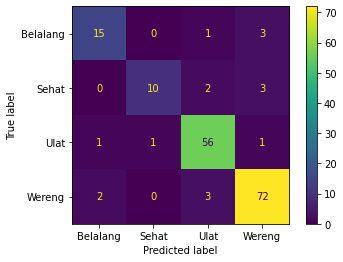

              precision    recall  f1-score   support

    Belalang       0.83      0.79      0.81        19
       Sehat       0.91      0.67      0.77        15
        Ulat       0.90      0.95      0.93        59
      Wereng       0.91      0.94      0.92        77

    accuracy                           0.90       170
   macro avg       0.89      0.84      0.86       170
weighted avg       0.90      0.90      0.90       170



In [ ]:
from sklearn.model_selection import KFold

dataset = ConcatDataset([train_dataset, test_dataset])
k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)
avg_train_loss = []
avg_val_loss = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  
  train_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn, sampler = train_sampler)

  images,targets = next(iter(train_loader))

  images = list(image for image in images)
  targets = [{k:v for k, v in t.items()} for t in targets]
  
  # output = model(images, targets)

  device = torch.device("cuda")
  
  model = model.to(device)

  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

  train_error =[]
  num_epochs=25
 
  for epoch in range(num_epochs):
    x = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_error.append(x)
  avg_train_loss.append(sum(train_error) / len(train_error))

  #  MELAKUKAN PREDIKSI
  predict = []
  folder_dir = "/content/drive/MyDrive/Ta/Dataset/valid/"
  for i in range(170):
    img, _ = test_dataset[i]
    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]

    x = pred['labels'][pred['scores']>0.8]
    hasil =  x.detach().cpu().numpy()
    # print(hasil)
    if hasil == 1:
      predict.append(' Belalang')
    elif hasil == 2 :
      predict.append(' Sehat')
    elif hasil == 3:
      predict.append(' Ulat')
    elif hasil == 4:
      predict.append(' Wereng')
  

    

  # MENAMPILKAN EVALUASI TRAINING 
  df_hasil_pred = pd.DataFrame(predict)
  df_hasil_pred [1] = pd.DataFrame(test_labels)
  import matplotlib.pyplot as plt
  import numpy
  from sklearn import metrics

  actual = df_hasil_pred[0]
  predicted = df_hasil_pred[1]

  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Belalang', 'Sehat', 'Ulat', 'Wereng'])

  cm_display.plot()
  plt.show()
  from sklearn.metrics import classification_report
  print(classification_report(actual, predicted, target_names=['Belalang', 'Sehat', 'Ulat', 'Wereng']))

**SUB PLOT LOSS TRAINING**



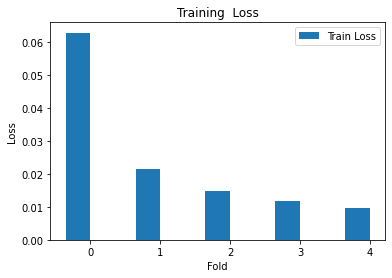

In [ ]:
index = np.arange(5)
x_label = [0,1,2,3,4]
bar_width = 0.35

fig, ax = plt.subplots()
train = ax.bar(index, avg_train_loss, bar_width,
                label="Train Loss")

ax.set_xlabel('Fold')
ax.set_ylabel('Loss')
ax.set_title('Training  Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_label)


ax.legend()

plt.show()

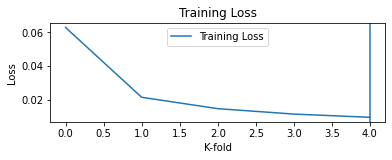

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(avg_train_loss, label='Training Loss')
# ?plt.plot(avg_val_loss, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.axvline(4,  label="Epoch")
# plt.ylabel('merror')
plt.ylabel('Loss')
plt.xlabel('K-fold')
plt.show()

**`MENAMPILKAN GAMBAR HASIL PREDIKSI `**

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
img, _ = test_dataset[50]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

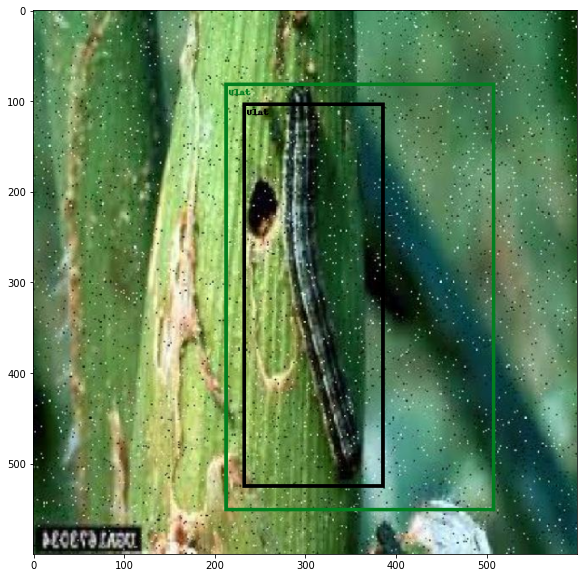

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))